In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer
import wordcloud  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, 'scripts')
import printController
import stringTransformation
import plotController
import fileManagementController
import dataFrameController
import directoryController

In [3]:
pwd_path = directoryController.getMainDirectory()
directoryController.goToMainDirectory(pwd_path)
csv_already_exists = fileManagementController.checkIfFileExists(step = 1)
df = dataFrameController.loadDataFrame(csv_already_exists)

## QUESTION 1: What are the Ids that posted at least for 4 years and the years that they posted on average at least once a week?

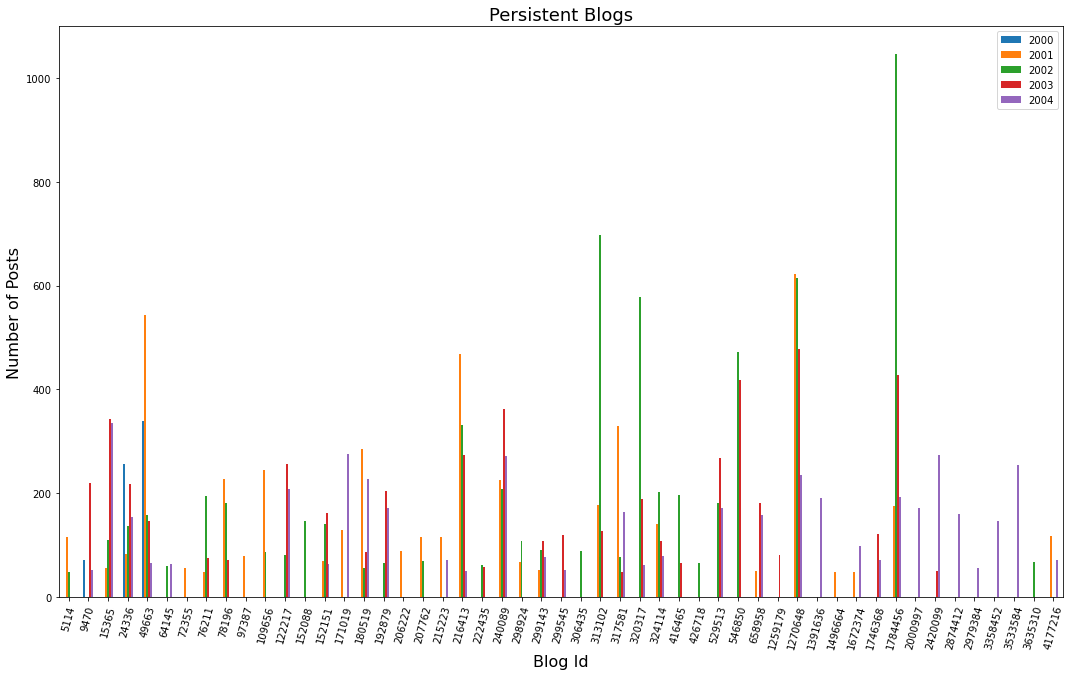

In [4]:
id_annually = df.groupby('Id').resample('A', on='Date').size()
blog_filter = ((id_annually >= 48) & (id_annually.groupby('Id').count() > 3))
id_annually_unstacked = id_annually[blog_filter].unstack()
id_annually_unstacked.columns = [2001, 2002, 2000, 2003, 2004]
id_annually_unstacked = id_annually_unstacked[[2000, 2001, 2002, 2003, 2004]]
plotController.barPlot(id_annually_unstacked, xlabel = 'Blog Id', ylabel = 'Number of Posts', title = 'Persistent Blogs', fig_size = (18, 10.5), rotation = 75, ax_fontsize = 16, title_fontsize = 18)

#### ANSWER: Persistent blogs are blogs that don't give up at the beggining of their journey and keep on posting for at least 4 years. In the chart we see the blog Ids from the these blogs and the years that they posted at least 48 times (on average once a week). The goal here was to identify these blogs and see the difference between them, if there are outliers (related to posting too much). In this case, Id 1784456 was the winner in 2002.

## QUESTION 2: How many times blogs usually post?

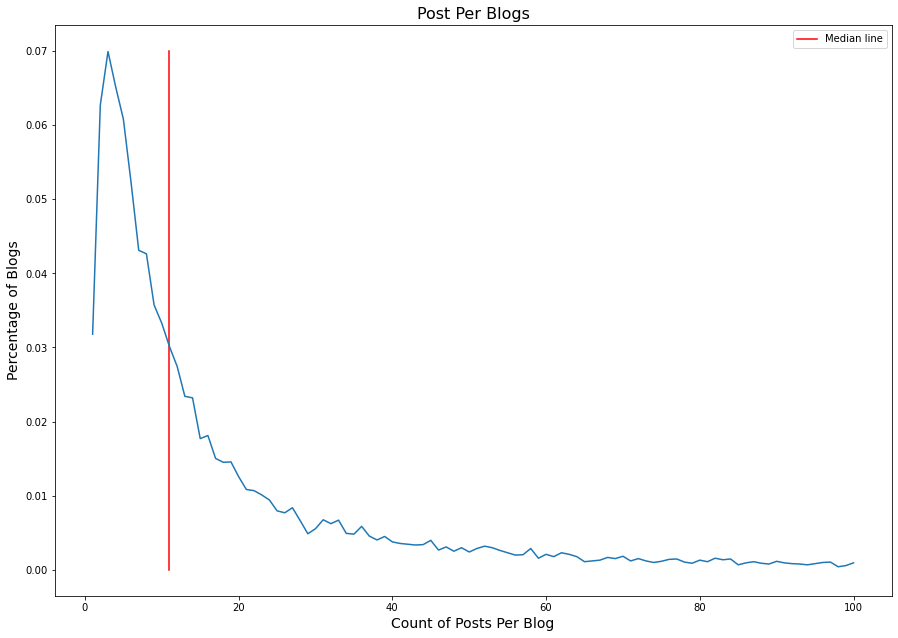

In [5]:
id_p = df.groupby('Id')['Post'].size()
id_post_norm = id_p.value_counts(normalize = True).sort_index()
id_post_under100 = id_post_norm[id_post_norm.index <= 100]
plotController.combinePlots(id_post_under100.index, id_post_under100.values,  xlabel = 'Count of Posts Per Blog', ylabel = 'Percentage of Blogs', title = 'Post Per Blogs', add_plot = plotController.combinePlots([id_p.median(), id_p.median()], [0, 0.07], color = 'red', label = 'Median line', show = False))

#### ANSWER: The plot was reduced to the first 100 values from the count of posts per blog, so one can have a better understand of the most informative part of the plot; 6.99% of blog posts were made 3 times being the mode here; The median of the count of posts per blog is 11 times (red line), in other words, half of the blogs posted 11 times or less at the period of study (1999 - 2006).

## QUESTION 3: What is the Id of the blog that posted the most?

In [6]:
id_max = id_p[id_p == id_p.max()]
df[df.Id == 449628].resample('A', on='Date').size()

Date
2002-12-31    1346
2003-12-31    2378
2004-12-31     497
Freq: A-DEC, dtype: int64

#### ANSWER: The blog that posted the most had the Id 449628 and posted 4221 times in total, being 1346 in 2002, 2378 in 2003 and 497 in 2004.

## QUESTION 4: Which categories there are in Theme column?

In [7]:
df['Theme'] = df.Theme.astype('category').cat.as_ordered()
theme_unique = df.Theme.unique()
theme_unique

[Student, BusinessServices, Education, indUnk, Technology, ..., Automotive, Maritime, LawEnforcement-Security, Environment, InvestmentBanking]
Length: 40
Categories (40, object): [Accounting < Advertising < Agriculture < Architecture ... Telecommunications < Tourism < Transportation < indUnk]

#### ANSWER: The theme column has 40 categories, including indUnk, Student, Arts, Engineering, Religion.

## QUESTION 5: What are the number of posts per each theme?

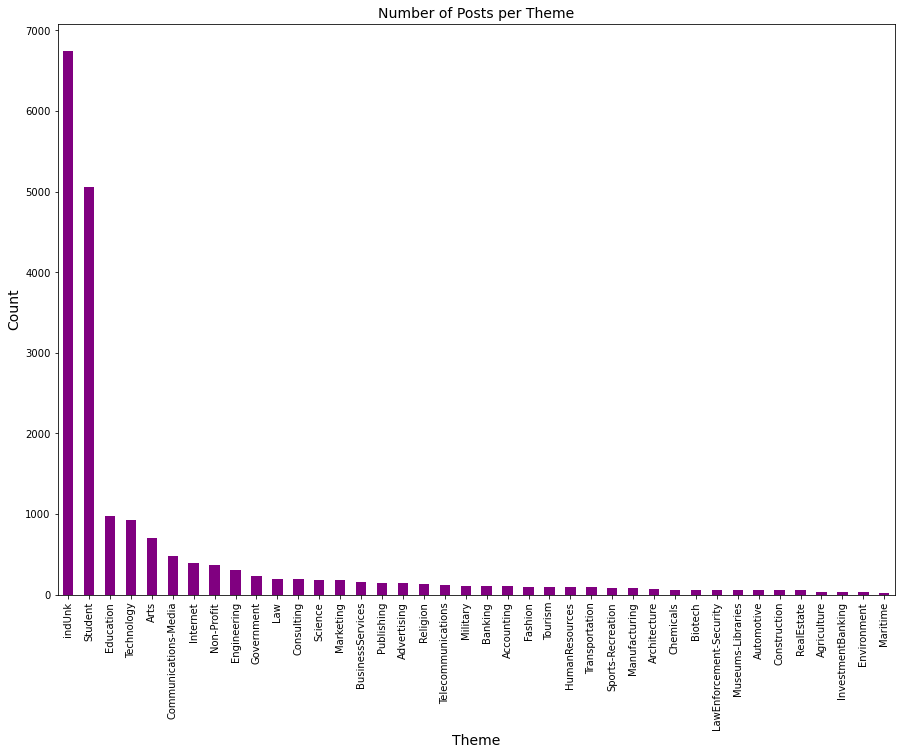

In [8]:
id_theme = df.groupby('Id')['Theme'].first()
plotController.barPlot(id_theme.value_counts(), xlabel = 'Theme', ylabel = 'Count', title = 'Number of Posts per Theme', color = 'purple', rotation = 90, title_fontsize = 14)

####  ANSWER: indUnk is the theme most posted (6743), followed by Student (5063) and the last theme is Maritime (17). 

## QUESTION 6: What is the age group that post the most?

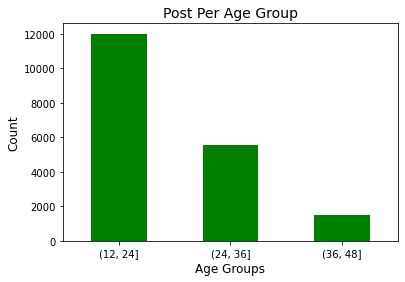

In [9]:
id_theme_age = df.groupby('Id')[['Theme','Age']].first() 
age_cat = pd.cut(id_theme_age['Age'],[12, 24, 36, 48])
plotController.barPlot(age_cat.value_counts(), xlabel = 'Age Groups', ylabel = 'Count', title = 'Post Per Age Group', color = 'green', ax_fontsize = 12, title_fontsize = 14, fig_size = (6, 4))

#### ANSWER: The age group that posts the most is from 12 - 24 years old, having posted 12.005 times (62,88% of the post on this dataset).

## QUESTION 7: Percentage of blog theme per age group

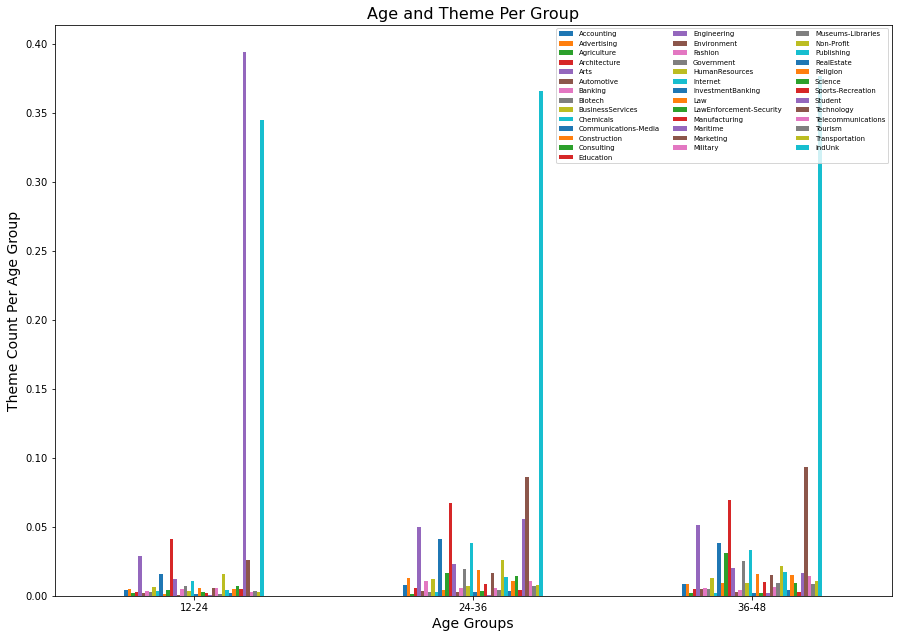

In [10]:
rename_categories = {'(12, 24]': '12-24', '(24, 36]': '24-36', '(36, 48]': '36-48'}
id_theme_age['Age_bins'] = age_cat.astype(str).map(rename_categories).astype('category')
id_theme_age.Age_bins.value_counts(normalize = True)
age_theme_count = id_theme_age.groupby('Age_bins')['Theme'].value_counts(normalize = True) 
age_theme_count_unstacked = age_theme_count.unstack()
plotController.barPlot(age_theme_count_unstacked, xlabel = 'Age Groups', ylabel = 'Theme Count Per Age Group', title = 'Age and Theme Per Group', leg_loc = 'upper right', leg_ncol = 3, leg_fontsize = 'x-small')

#### ANSWER: In the 12-24 age group, the theme most posted is Student followed by indUnk; In the 24-36 and 36-48 age groups, the indUnk theme is the most posted, followed by Technology. So it seems they present the same theme interest pattern.

## QUESTION 8: What is the relation between star Sign and Theme?

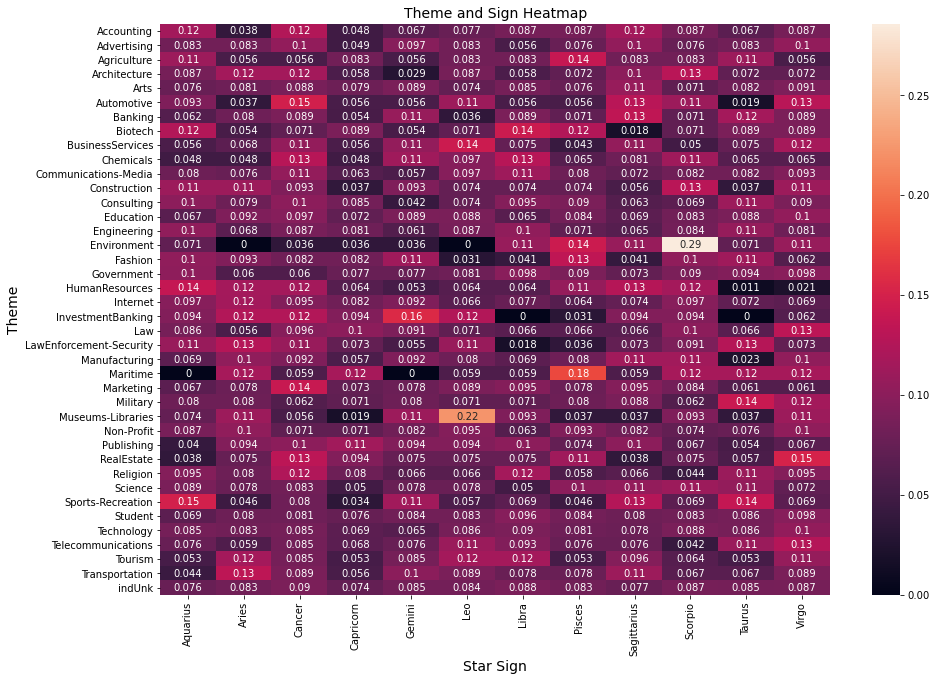

In [11]:
df['Sign'] = df.Sign.astype('category').cat.as_ordered()
df['Sex'] = df.Sex.astype('category').cat.as_ordered()
sign_theme_sex = df.groupby('Id')[['Theme', 'Sign', 'Sex']].first()
sign_theme = sign_theme_sex.groupby('Theme')['Sign'].value_counts(normalize=True).unstack()
sign_theme = sign_theme.fillna(0)
sign_theme.reset_index(inplace = True)
sign_names = ['Aries', 'Leo', 'Libra', 'Capricorn', 'Cancer', 'Sagittarius', 'Taurus', 'Pisces', 'Virgo', 'Scorpio', 'Aquarius', 'Gemini']
df_cross_sign_theme = pd.melt(sign_theme, id_vars = ['Theme'], value_vars = sign_names) 
sign_theme_crosstab = pd.crosstab(df_cross_sign_theme['Theme'], df_cross_sign_theme['Sign'], values = df_cross_sign_theme['value'], aggfunc = 'first')
plotController.heatMapPlot(sign_theme_crosstab, annot = True,  xlabel = 'Star Sign', ylabel = 'Theme', title = 'Theme and Sign Heatmap')

#### ANSWER: The heatmap shows the favorite themes of each sign in this dataset. Leo star sign has 22% of posts in Museums-Libraries theme and none about Environment; Scorpio posts are 29% about Environment.

## QUESTION 9: What is the relation between Sex and Theme?

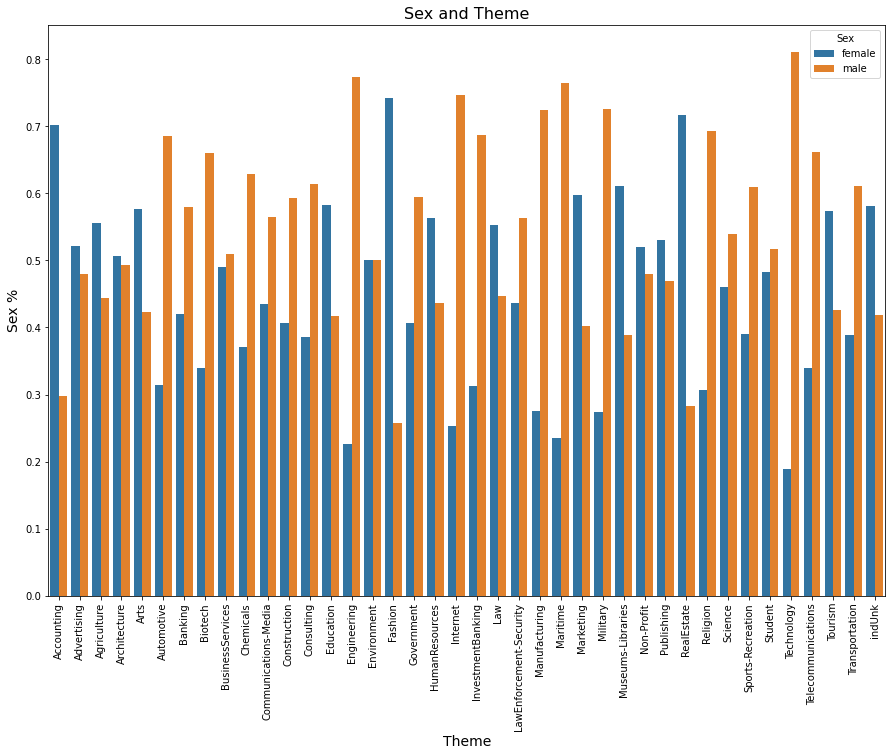

In [12]:
df.groupby('Id')['Sex'].first().value_counts()
sex_theme = sign_theme_sex.groupby('Theme')['Sex'].value_counts(normalize=True).unstack()
sex_theme.reset_index(inplace = True)
df_sex_theme = pd.melt(sex_theme, id_vars = ['Theme'], value_vars = ['female', 'male'])
plotController.barPlot(df_sex_theme, rotation = 90, xlabel = 'Theme', ylabel = 'Sex %', title = 'Sex and Theme', hue = 'Sex', sns_plot = True, sns_x = 'Theme', sns_y = 'value')

#### ANSWER: This plot shows how theme is related to sex. Accounting posts are made 70% by female sex and Technology is 81% by male sex, for example. It is important to know that this dataset has a very close amount of women and men (male: 9549 and female: 9543).

## QUESTION 10: Themes where women post more than men

In [13]:
fem = df_sex_theme[df_sex_theme.Sex == 'female']['value'] 
mal = df_sex_theme[df_sex_theme.Sex == 'male']['value']  
mal.reset_index(drop = True, inplace = True)
comp = fem > mal
df_sex_theme[df_sex_theme.Sex == 'female'][comp]['Theme']

0            Accounting
1           Advertising
2           Agriculture
3          Architecture
4                  Arts
13            Education
16              Fashion
18       HumanResources
21                  Law
25            Marketing
27    Museums-Libraries
28           Non-Profit
29           Publishing
30           RealEstate
37              Tourism
39               indUnk
Name: Theme, dtype: category
Categories (40, object): [Accounting < Advertising < Agriculture < Architecture ... Telecommunications < Tourism < Transportation < indUnk]

#### ANSWER: Women post more than men in these themes: Accounting, Advertising, Agriculture, Architecture, Arts, Education, Fashion, HumanResources, Law, Marketing, Museums-Libraries, Non-Profit, Publishing, RealEstate, Tourism, and indUnk.

## QUESTION 11: Most common words in the indUnk theme with two different approachs

### 11.1: indUnk most common words with nltk

In [14]:
df['Post'] = df['Post'].str.strip()
long_str_indUnk = stringTransformation.getLongString(df, 'Theme', 'Post', 'indUnk')
no_stop_already_exists = fileManagementController.checkIfFileExists(step = 2, path = pwd_path)
no_stops_word_list = dataFrameController.loadData(long_str_indUnk, pwd_path, no_stop_already_exists)

wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet') 
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops_word_list]
bowl_of_words = Counter(lemmatized)

print(bowl_of_words.most_common(10))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carlosdias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('like', 98484), ('one', 83573), ('nbsp', 82715), ('get', 74445), ('time', 73619), ('urllink', 70430), ('know', 68938), ('go', 59912), ('would', 57259), ('day', 57040)]


#### ANSWER: The 10 most common words in indUnk: 'like', 'one', 'nbsp', 'get', 'time', 'urllink', 'know', 'go', 'would', and 'day'.

### 11.2: Most common words with wordcloud in the indUnk theme

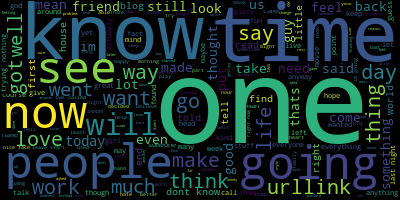

In [15]:
long_str_indUnk_clean = re.sub(r'[\d+\'"\?!\.,\/\\\^%#:;&*()\[\]\+=@~`\-_<>|\{\}]', '', long_str_indUnk)
wordcloud = wordcloud.WordCloud()
wordcloud.generate(long_str_indUnk_clean.lower())
wordcloud.to_image()

#### ANSWER: The most common words in indUnk: 'one', 'time', 'know', 'will', 'see', 'people', 'going', 'now', 'urllink', and 'love'.

## QUESTION 12: Grouping words by topic with feature_extraction.text and LDA model

### 12.1: Most common words in the Religion theme

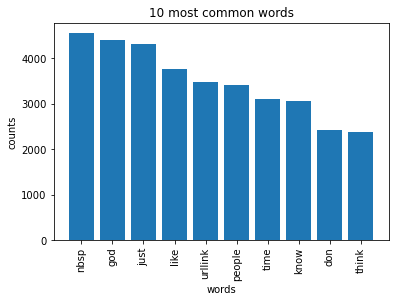

In [17]:
count_vectorizer = CountVectorizer(stop_words = 'english')
data_count = count_vectorizer.fit_transform(df[df.Theme == 'Religion']['Post'])
plotController.plot10MostCommonWords(data_count, count_vectorizer)

#### ANSWER: The 10 most common words in Religion: 'nbsp', 'god', 'just', 'like', 'urllink', 'people', 'time', 'know', 'don', and 'think'. 

### 12.2: Topics found by the LDA model in the Religion theme

In [18]:
number_of_topics = 10
number_of_words = 5
lda = LDA(n_components = number_of_topics)
lda.fit(data_count)

print("Topics found via LDA:")
printController.printTopicsLDA(lda, count_vectorizer, number_of_words)

Topics found via LDA:

Topic #0:
bush urllink marriage president people

Topic #1:
urllink jesus god church people

Topic #2:
nbsp urllink like know just

Topic #3:
said people study health women

Topic #4:
war iraq said women al

Topic #5:
god people know church love

Topic #6:
just like time really know

Topic #7:
like time just ve life

Topic #8:
im just like dont people

Topic #9:
urllink com internet heidi protocol


#### ANSWER: 10 Topics found by LDA model: Topic 1: bush urllink marriage president people; Topic 2: urllink jesus god church people; Topic 3: nbsp urllink like know just; Topic 4: said people study health women; Topic 5: war iraq said women al; Topic 6: god people know church love; Topic 7: just like time really know; Topic 8: like time just ve life; Topic 9: im just like dont people; Topic 10: urllink com internet heidi protocol.